## Libraries

In [1]:
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

from utils.dataset import create_model_dataset, to_temporal_dataset, load_val_test_dataset, fill_domain_nan
from utils.load import read_config, load_dataset
from training.train import Trainer
from utils.miscellaneous import get_numerical_times, calculate_speed_ups, SpatialAnalysis, get_model
from utils.visualization import plot_breach_distribution, PlotRollout


In [13]:
def load_trained_model(config, model_name, model_dir):
    '''This function loads a trained model given a configuration file
    The reason why it's so long is that the loading must be consistent with the model creation'''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataset_parameters = config['dataset_parameters']
    scalers = config['scalers']
    selected_node_features = config['selected_node_features']
    selected_edge_features = config['selected_edge_features']

    train_dataset, _, _, scalers = create_model_dataset(
        'DR49', 'DR49', trani_size=1, scalers=scalers, device=device, **dataset_parameters,
        **selected_node_features, **selected_edge_features
    )

    temporal_dataset_parameters = config['temporal_dataset_parameters']

    temporal_train_dataset = to_temporal_dataset(train_dataset, **temporal_dataset_parameters)

    node_features, edge_features = temporal_train_dataset[0].x.size(-1), temporal_train_dataset[0].edge_attr.size(-1)
    num_nodes, num_edges = temporal_train_dataset[0].x.size(0), temporal_train_dataset[0].edge_attr.size(0)

    previous_t = temporal_dataset_parameters['previous_t']

    model_parameters = config['models']
    model_type = model_parameters.pop('model_type')

    if model_type == 'GNN':
        model_parameters['edge_features'] = edge_features
    elif model_type == 'MLP':
        model_parameters.num_nodes = num_nodes

    model = get_model(model_type)(
        node_features=node_features,
        previous_t=previous_t,
        device=device,
        **model_parameters).to(device)

    trainer_options = config['trainer_options']
    try:
        batch_size = trainer_options.pop('batch_size')
    except:
        pass

    lr_info = config['lr_info']

    # Model optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=lr_info['step_size'], gamma=lr_info['gamma'])

    # Training (but only used to load here)
    trainer = Trainer(optimizer, lr_scheduler, **trainer_options)
    trainer._load_model(model, model_name=model_name, save_dir=model_dir)

    return model, scalers

### Plot details

To ensure readability of big plots

In [14]:
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 75
mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['savefig.bbox'] = 'tight'

mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'

## Dataset creation

In [15]:
# Specify type of model to be used or its directory
model_type = 'SWEGNN'
results_dir = f'results/best_models/{model_type}'

# ONLY IF YOU USE SWEGNN USE THE LINE BELOW
# In the Pareto_front folder you can choose a smaller and faster model
#  results_dir = 'results/Pareto_front'

In [23]:
from utils.dataset import get_temporal_test_dataset_parameters

def load_val_test_dataset(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cpu')

    dataset_parameters = config['dataset_parameters']
    scalers = config['scalers']
    selected_node_features = config['selected_node_features']
    selected_edge_features = config['selected_edge_features']

    _, val_dataset, test_dataset, scalers = create_model_dataset(
        'DR49', 'DR49', scalers=scalers, device=device, **dataset_parameters,
        **selected_node_features, **selected_edge_features
    )

    temporal_dataset_parameters = config['temporal_dataset_parameters']
    temporal_test_dataset_parameters = get_temporal_test_dataset_parameters(
        config, temporal_dataset_parameters)

    return val_dataset, test_dataset, temporal_test_dataset_parameters

In [24]:
# config contains all properties to describe datasets, training, and testing
config = read_config(f'{results_dir}/config1.yaml')

config['models']['hid_features'] = 64       # num hidden features
config['models']['K'] = 8                   # num GNN layers

# Change these lines here to change the testing dataset
#config['dataset_parameters']['test_size'] = 'big_random_breach' #dataset 3
#config['dataset_parameters']['test_size'] = 'random_breach'     #dataset 2
#config['dataset_parameters']['test_size'] = 'dr49'              #dataset 1
config['dataset_parameters']['test_size'] = 'DR49'         #dataset dr49


# Then you obtain a split in validation and testing datasets (here we don't care about the training one)
val_dataset, test_dataset, temporal_test_dataset_parameters = load_val_test_dataset(config)

In [25]:
# Check the distribution of breaches in datasets 2 and 3
# fig, ax = plt.subplots(figsize=(6,6))
# plot_breach_distribution(test_dataset, ax=ax, with_label=True);

In [26]:
val_dataset[0].x

tensor([[-0.0132,  0.0000,  0.2348],
        [-0.0075, -0.0170,  0.2299],
        [-0.0010, -0.0111,  0.2260],
        ...,
        [ 0.0178, -0.0295,  0.5295],
        [ 0.0079, -0.0079,  0.5706],
        [-0.0031,  0.0000,  0.5788]])

In [27]:
from torch_geometric.utils import scatter

def get_sufficient_k_hops(edge_index, WD, cover_percentage=0.999):
    """Determine how many K-hops are needed to cover the cells changed in one time step
    cover_percentage: float
        Percentage of cells that need to be covered by the GNN k-hops
    """
    assert WD.dim() == 2, "The input WD matrix should contain the full original simulation [NxT]"

    row = edge_index[0]
    col = edge_index[1]

    num_nodes = WD.shape[0]
    time_steps = WD.shape[1]
    water_t1 = torch.stack([WD[:,t]>0 for t in range(1,time_steps)]).T

    fake_water = torch.zeros_like(WD)
    fake_water[WD>0] = 1
    fake_water = fake_water[:,:-1]

    changes_fully_covered = (fake_water[water_t1]>0).all()

    k=0
    while not changes_fully_covered:
        fake_water = scatter(fake_water[row], col, reduce='sum', dim=0, dim_size=num_nodes) + fake_water
        fake_water[fake_water>0] = 1
        changes_fully_covered = (fake_water[water_t1]>0).all()
        if cover_percentage < 1:
            changes_fully_covered = (fake_water[water_t1]>0).sum() > cover_percentage*water_t1.sum()
        else:
            changes_fully_covered = (fake_water[water_t1]>0).all()
        k+=1
        if k>50:
            print('This number of k-hops is probably wrong')
            break

    return k

In [67]:
import numpy as np

([get_sufficient_k_hops(data.edge_index, data.WD[:,1:], cover_percentage=0.995) for data in test_dataset])

This number of k-hops is probably wrong
This number of k-hops is probably wrong
This number of k-hops is probably wrong


[6, 51, 51, 6, 17, 51, 6, 6, 6, 13]

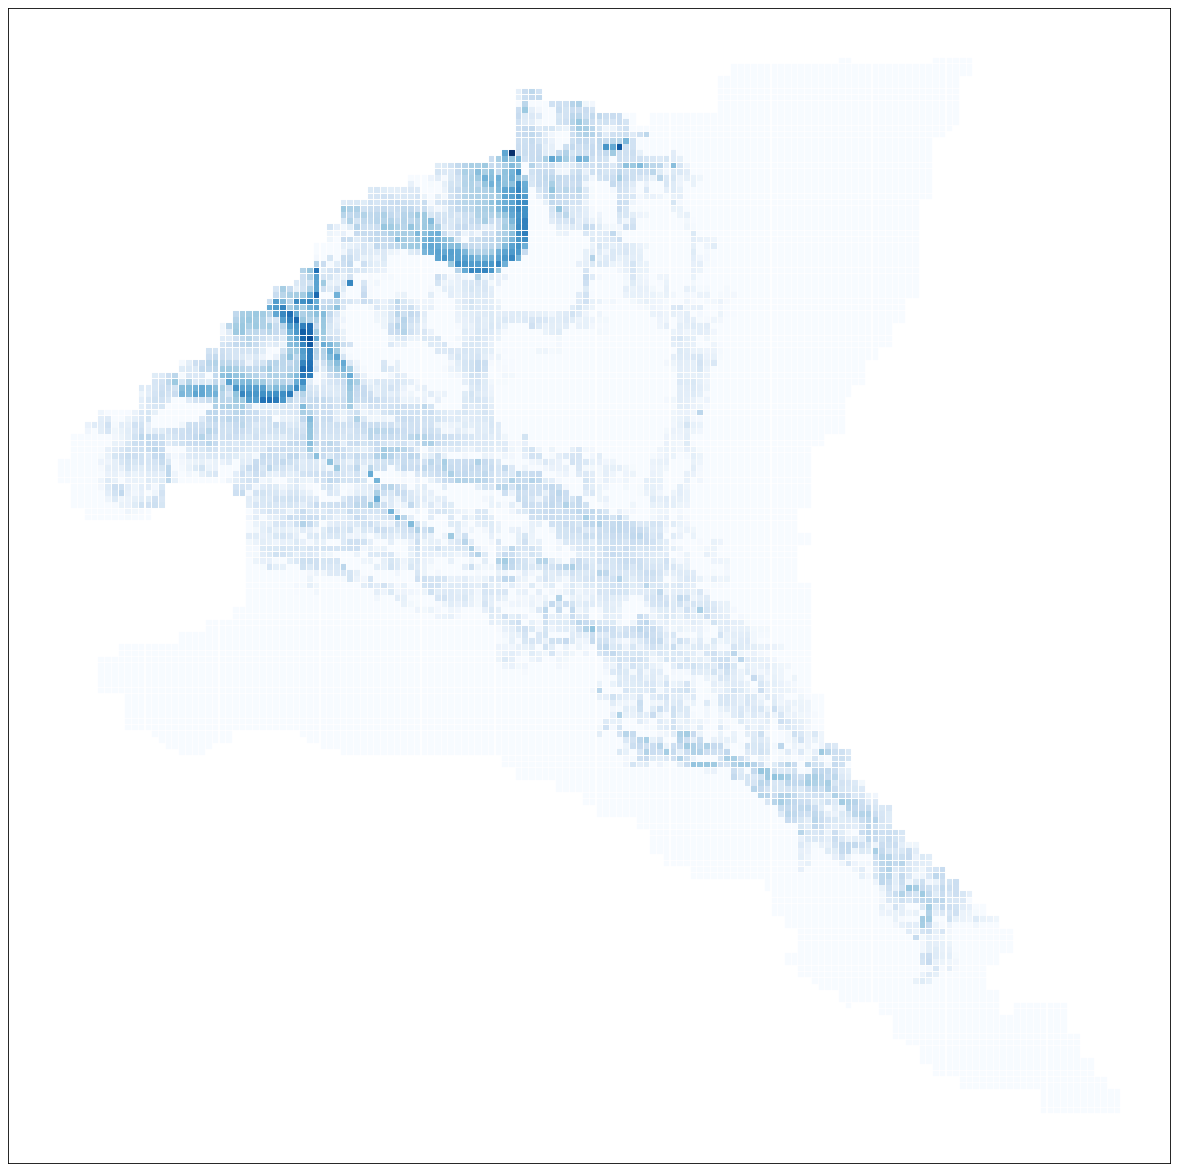

In [84]:
from utils.visualization import *

data = test_dataset[2]

pos, graph, mesh = get_info_from_pyg(data)

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(graph, pos=pos, node_color=data.WD[:,-1], node_shape='s', node_size=20, cmap='Blues')

# Model

## Load trained model

This notebook is not for training the model. For training, please run main.py

In [6]:
# If you want to change model, be sure to change directory of the saved model, as the config file changes
model, scalers = load_trained_model(config, model_name='cleanplanet.h5', model_dir=results_dir)

TypeError: create_model_dataset() missing 1 required positional argument: 'test_dataset_name'

## Check predictions

All predictions are saved in the object spatial_analyser, that can be used for all plotting and analyses

In [ ]:
# run and store all simulations in test_dataset in this object here
spatial_analyser = SpatialAnalysis(model, test_dataset, **temporal_test_dataset_parameters)

In [ ]:
# get some parameters for the coming function
maximum_time = test_dataset[0].WD.shape[1]          # number of total time steps/ prediction horizon
dataset_parameters = config['dataset_parameters']
test_size = dataset_parameters['test_size']         # Which test dataset you are using
temporal_res = dataset_parameters['temporal_res']   # temporal resolution

# get simulation times for numerical model 
# numerical_times = get_numerical_times(test_size, temporal_res, maximum_time, 
#                 **temporal_test_dataset_parameters,
#                 overview_file='database/raw_datasets/overview.csv')

In [ ]:
test_dataset

[Data(edge_index=[2, 23307], edge_attr=[23307, 3], x=[11856, 3], y=[11856, 2, 50], DEM=[11856], WD=[11856, 50], V=[11856, 50], pos=[11856, 2], temporal_res=60, area=[11856, 1])]

In [ ]:
# Obtain loss over the test dataset and prediction times
rollout_loss = spatial_analyser._get_rollout_loss(type_loss='RMSE')
model_times = spatial_analyser.prediction_times

print('test roll loss WD:',rollout_loss.mean(0)[0].item())
print('test roll loss V:',rollout_loss.mean(0)[1:].mean().item())

test roll loss WD: 2.307960271835327
test roll loss V: 0.3867792785167694


In [ ]:
# Determine speed-up
# avg_speedup, std_speedup = calculate_speed_ups(numerical_times, model_times)
# print(f'mean speed-up: {avg_speedup:.2f}\nstd speed-up: {std_speedup:.3f}')

# Plots

## Dataset statistics

In [ ]:
# Rank all simulations in a dataset either by 'loss' or 'CSI'
# sorted_ids = spatial_analyser.plot_loss_per_simulation(type_loss='RMSE', ranking='loss', figsize=(20,12))

In [ ]:
# fig = spatial_analyser._plot_rollouts(type_loss='RMSE')

In [ ]:
# CSI in time (you can also plot the F1 score in the same way)
# fig, CSI = spatial_analyser.plot_CSI_rollouts(water_thresholds=[0.05, 0.3])
# print(CSI.mean(1).mean(1))

# fig, F1 = spatial_analyser.plot_F1_rollouts(water_thresholds=[0.05, 0.3])
# print(F1.mean(1).mean(1))

In [ ]:
# Summary using bo plots
# fig = spatial_analyser.plot_summary(numerical_times, figsize=(15,4))

## Single simulations

In [ ]:
# Change id according to which simulation you want to run and visualize
id_dataset = 0

rollout_plotter = PlotRollout(model, test_dataset[id_dataset], scalers=scalers, 
    type_loss='RMSE', **temporal_test_dataset_parameters)

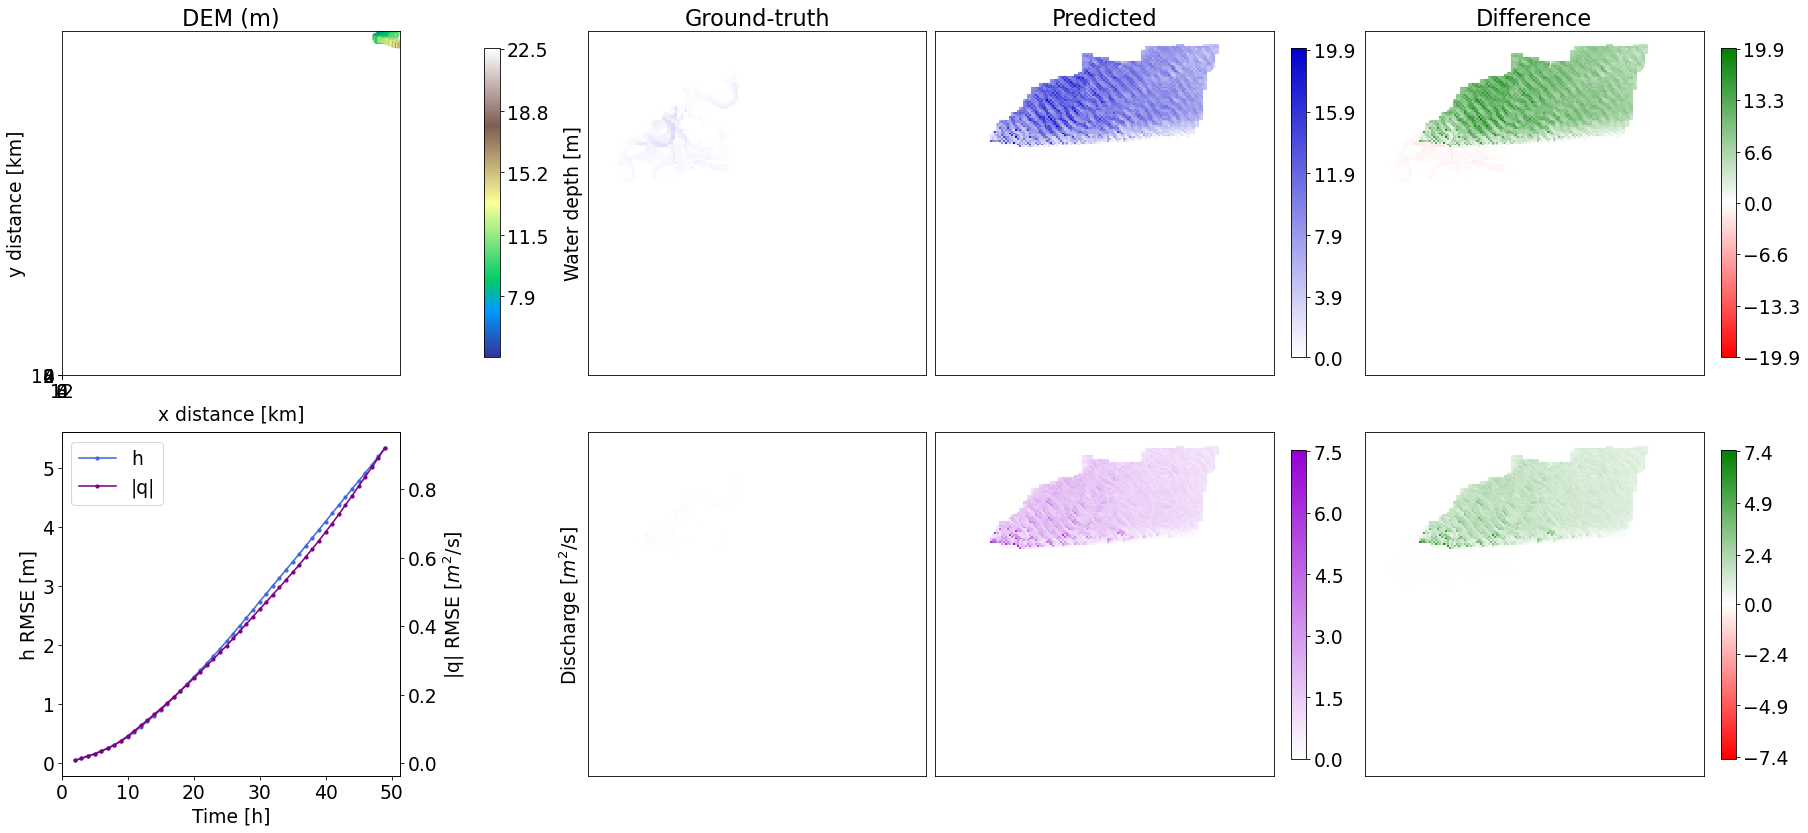

In [ ]:
# summary plot
fig = rollout_plotter.explore_rollout()

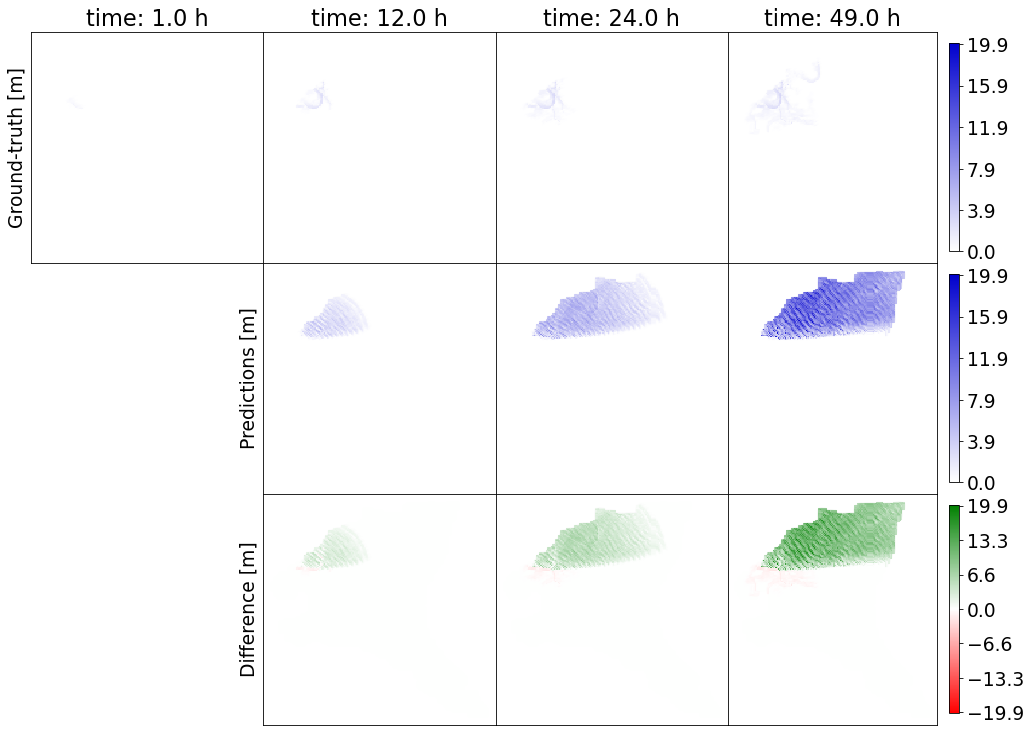

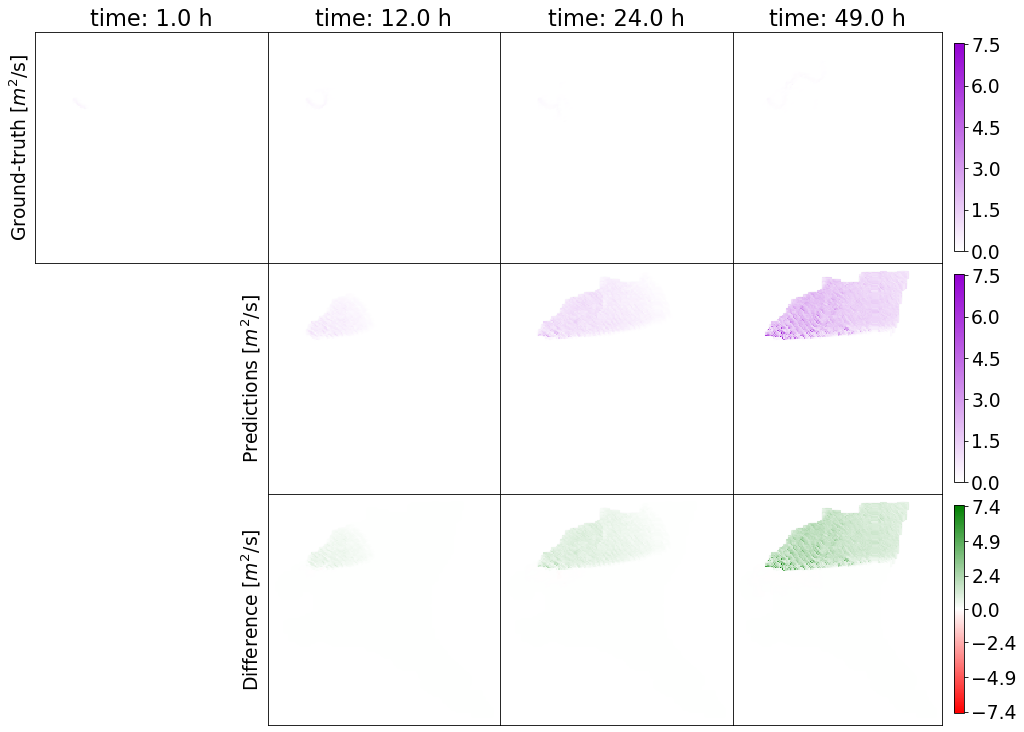

In [ ]:
# Plot solution at different time steps (by default there are always input time and final time)
plot_times = [8,22]

# plot water depths
rollout_plotter.compare_h_rollout(plot_times)

# plot discharges
rollout_plotter.compare_v_rollout(plot_times)

### Single spatial analysis

tensor([2.3080, 0.3868])

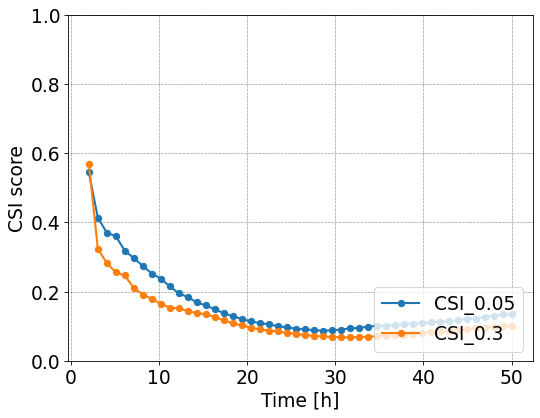

In [ ]:
rollout_plotter._plot_metric('CSI')
rollout_plotter._get_rollout_loss()

### Video

In [ ]:
# Run this cell to create the video (for more information check its documentation)
# rollout_plotter.create_video()
# rollout_plotter.save_video(path=f'results/test_{id_dataset:02d}', fps=10)